# IXO Modelling

**Terminology:**

Tokens:
* c_ - IXO-Cosmos equivalent of Ethereum tokens
* native - native to IXO-Cosmos network
* cIXOS - staking tokens 
* cIXO - utility tokens

Mechanisms:
* Pool: pool of specific token / collateral type
* Bridge: pre-IBC mirror between Ethereum and IXO-Cosmos, implementation is irrelevant for now
* Market maker: issues IXO tokens in exchange for DAI
* Brokerage: issues IXOS / staking tokens to delegators

Network:
* nodes represent mechanisms, pools, and participants
* edges represent relationships, such as token balances, amongst mechanisms, pools, and participants
* the total pool balance is the sum of all edges conected to that pool

**Actor flow:**

1. Participant buys into market maker with Dai, and is given Ethereum based IXO tokens.
2. Participant stakes IXO into the brokerage mechanism in exchange for IXOS. The IXO stake is backed by a proportion of the DAI collateral pool.
3. The IXO and IXOS pools are mirrored on the IXO-Cosmos network, and backed by DAI - post IBC these assets can be made native to the IXO-Cosmos network.
4. cIXO become utility tokens that can be spent in IXO-Cosmos network, and minted through block rewards to be rewarded to actors in the system. The utility comes from the asset backing of the cIXO tokens in the brokerage.

**Working example:**

1. Participant purchases 100 IXO tokens @ 0.1 DAI per IXO for a total of 10 DAI.
2. Participant provides liquidity in brokerage contract by depositing 50 IXO, retaining 50 IXO for the time being. The asset backing is provided by the bonding curve Dai collateral pool.
3. Participant is rewarded with 50 IXOS tokens to represent the proportion of the liquidity provided.
4. These IXOS tokens are mirrored and can be used within the IXO-Cosmos network as equivalent cIXOS tokens, these are low velocity and are essentially staked for IXO-Cosmos incentive rewards.
5. Participants within the IXO-Cosmos network, who are incentivized/rewarded with cIXO tokens for supporting the network roles, may atomic swap/mirror their cIXO tokens for IXO tokens and in effect DAI via the bonding curve.

**Observations:**

* Based on last two actions - what is the best way to couple the cIXO token value to the DAI reserve to maintain the cross blockchain peg?
* Objective - make the cIXO utility token stable.
* cIXOS staked on IXO-Cosmos side for various incentive rewards.

![system-diagram](./ixo-liquidity-diagram_v2.png)

### Dependancies

In [1]:
from modules import *
%matplotlib inline

### Liquidity Mechanisms and Actors Overview

In [2]:
from enum import Enum, auto
class Nodes(Enum):
    POOL = auto() # Pool of specific token / collateral
    FEE_POOL = auto() # Black-box for fee collection
    STAKE_POOL = auto() # Black-box for stake collection
    # Mechanisms
    MARKET_MAKER = auto() # Issues IXO tokens in exchange for DAI
    BROKERAGE = auto() # Issues IXOS / staking tokens to delegators
    # Actors
    SERVICE_PROVIDER = auto() # makes claims about contributions and state of project
    EVALUATOR = auto() # validates claims
    DELEGATOR = auto() # stakes into the brokerage to provide liquidity
    PARTICIPANT = auto() # generic type for any user of IXO-Cosmos utility tokens
    # Generic actors
    GENERIC_DELEGATOR = auto()
    GENERIC_PARTICIPANT = auto()
    
class Edges(Enum):
    BALANCE = auto()
    BRIDGE = auto() # IBC style mirror
    
# IBC Ethereum Peg-Zone:
# 1. IXO from AMM and DAI staked into reserve pool by delegators in exchange for IXOS
# 2. cIXO and cIXOS matched on IXO-Cosmos network
# 3. This mechanism can be spun down, while maintaining the liquidity created, when the IBC mechanism is operational

### Global Parameters

In [3]:
liquidity_provider_fee = .03 # percent
tax = 0 # exit tax - introduces friction and possibly funds to prime stability mechanisms
theta = 0 #.35 # Funding pool taxation - 0 implies all contributions allocated to market

# Supply pool initial parameters
initial_ixo_supply = 1660495658
initial_ixo_price = .003
initial_ixo_reserve = initial_ixo_supply * initial_ixo_price

# Founders staked at 1:10 -- where DAI/IXO pair are entered into liquidity pool to receive staking vouchers, founders receive 1/10th of the value or share of the pool
founders_stake = .1 # percent
initial_ixos_supply = 83024783 # initial_ixo_supply * founders_stake # initial supply of staking vouchers

initial_ixo_price = .10 # average IXO price from ixo.world Euro cents
initial_ixos_price = .10 #.20 # staking voucher price from AMM in Euro cents

ixo_delegation_distribution_reserve = 1e6
ixo_delegation_distribution_supply = 1e6/initial_ixos_price #200e6 # 5 strategic delegations worth Euro 1 Mil each

# Augmented bonding curve parameters
# Hatch state
d0 = initial_ixo_reserve/1e6 # million DAI
p0 = initial_ixo_price # DAI per token

R0 =  d0*(1-theta) # million DAI
S0 = d0/p0

kappa = 1 # Bonding curve curvature - using an initial kappa value of 1 we can keep a constant token price for initial bootstrap phase

# Brokerage - Kyber Fed Price Reserve
# Policy to bound proposed conversion rate
sanity_rate = 10 # 1 DAI = 10 IXO
reasonable_difference = .1 # percent

# Target portfolio
# 50% DAI / 50% IXO

# Rebalancing
# Or: auto_instant - rebalance performed after every trade
time_spacing = 1 # time period after which to perform another rebalance
price_spacing_diff = .5 # percentage difference from last rebalance after which to perform another rebalance

# Pricing
maximum_spread = 0.02 # dictated by for example Kyber
minimum_spread = 0.005
spread = 0.01 # dependant on liquidity
quoted_price = 0 # TODO

# cadCAD configuration
days_in_month = 30 # approx.
time_steps = 12*days_in_month # days for more granularity - NB: all transaction rates in days

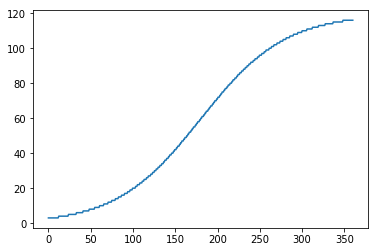

In [4]:
# Number of actors
# max_delegators = 20
# max_validators = 20
# max_service_providers = 20
max_participants = 120 # conservative

# Sigmoidal growth
default_inflection = time_steps/2
default_slope = 1/50

def sigmoidal_growth(step, max_value, inflection=default_inflection, slope=default_slope):
    y = np.divide(max_value, (1 + np.power(np.e, -np.multiply(np.subtract(step, inflection), slope))))
    y = np.floor(y)
    y[y < 0] = 0
    return y

x = np.linspace(0, time_steps, 500)
y = sigmoidal_growth(x, max_participants)

plt.plot(x, y)
plt.show()

### cadCAD Parameters and Initial State

In [ ]:
# cadCAD Parameter Sets
#####################################################################

# amm == automated market maker
# brk == brokerage

# params = {
#     'brokerage': {
#         'sanity_rate': 10,
#         'max_spread': .02,
#     }
# }

amm_initial_reserve, amm_initial_invariant, amm_initial_spot_price = \
    initialize_bonding_curve(initial_ixo_supply, initial_price=initial_ixo_price, kappa=kappa, theta=theta)

params = {
    'sweep': [1], # for selecting parameter sweep from results - unique ID
    # Automated Market Maker parameters
    'amm.kappa': [kappa],
    'amm.invariant': [amm_initial_invariant],
    'amm.tax_rate': [0],
    # Brokerage
    'brk.sanity_rate': [10], # 1 DAI = 10 IXO
    'brk.reasonable_diff': [.5], # percent
    'brk.rebalance_diff': [False], # percentage difference from last rebalance after which to perform another rebalance
    'brk.max_spread': [.02], # price
    'brk.min_spread': [.005],
    # Transactions
    'max_participants': [max_participants],
    'participant_seed_collateral': [100],
#     'supply_pool': [
#         {
#             'tx_rate': 0,
#             'tx_count': 6,
#             'tx_value': 1e6,
#         }
#     ],
#     'liquidity_pool': [
#         {
#             'tx_rate': .33,
#             'tx_count': 0,
#             'tx_value': 100e3,
#         }
#     ],
    'supply_pool_tx_rate': [0],
    'supply_pool_tx_count': [6],
    'supply_pool_tx_value': [1e6],
    'liquidity_pool_tx_rate': [.33],
    'liquidity_pool_tx_count': [0],
    'liquidity_pool_tx_value': [100e3]
}

initial_state = {
    'amm.supply': initial_ixo_supply,
    'amm.reserve': amm_initial_reserve,
    'amm.spot_price': amm_initial_spot_price,
    'lp.supply': 0,
    'lp.reserve': 0,
    'lp.spot_price': 0,
}

(amm_initial_reserve, amm_initial_invariant, amm_initial_spot_price)

(166049565.8, 10.0, 0.1)

### Brokerage / liquidity framework

In [ ]:
# Brokerage framework / liquidity provision (see Uniswap/Kyber)
# https://github.com/runtimeverification/verified-smart-contracts/blob/uniswap/uniswap/x-y-k.pdf
# Newly added... found post setting this up: https://github.com/BlockScience/uniswap

# e.g. reserve == DAI
# e.g. supply == IXO
# e.g. voucher == IXOS

def add_liquidity(reserve_balance, supply_balance, voucher_balance, tokens, value):    
    print('voucher_balance %s' % voucher_balance)
    if voucher_balance <= 0:        
        dr = value
        ds = tokens
        dv = tokens
        return (dr, ds, dv)
    
    alpha = value/reserve_balance
    
    dr = alpha*reserve_balance
    ds = alpha*supply_balance
    dv = alpha*voucher_balance
    
    #new_reserve = (1 + alpha)*reserve_balance
    #new_supply = (1 + alpha)*supply_balance
    #new_vouchers = (1 + alpha)*voucher_balance
    
    return (dr, ds, dv)

def remove_liquidity(reserve_balance, supply_balance, voucher_balance, tokens):
    reserve_balance = 0 # e.g. DAI
    supply_balance = 0 # e.g. IXO
    voucher_balance = 0 # e.g. IXOS
    
    alpha = tokens/voucher_balance
    
    dr = -alpha*reserve_balance
    ds = -alpha*supply_balance
    dv = -alpha*liquidity_token_balance
    
    #new_reserve = (1 - alpha)*reserve_balance
    #new_supply = (1 - alpha)*supply_balance
    #new_liquidity_tokens = (1 - alpha)*liquidity_token_balance
    
    return (dr, ds, dv)

# How much y received for selling dx?
def get_input_price(dx, x_balance, y_balance):
    rho = 0 # trade fee
    
    alpha = dx/x_balance
    gamma = 1 - rho
    
    dy = (alpha*gamma / (1 + alpha*gamma))*y_balance
    
    _dx = alpha*x_balance
    _dy = -dy
    
    #new_x = (1 + alpha)*x_balance
    #new_y = y_balance - dy
    
    return (_dx, _dy)

# How much x needs to be sold to buy dy?
def get_output_price(dy, x_balance, y_balance):
    rho = 0 # trade fee
    
    beta = dy/y_balance
    gamma = 1 - rho
    
    dx = (beta / (1 - beta))*(1 / gamma)*x_balance
    
    _dx = dx
    _dy = -beta*y_balance
    
    #new_x = x_balance + dx
    #new_y = (1 - beta)*y_balance
    
    return (_dx, _dy)

# Token trading
def collateral_to_token(value, reserve_balance, supply_balance):
    if reserve_balance == 0: return 0 #TODO: handle this case better
    dx,dy = get_input_price(value, reserve_balance, supply_balance)
    
    #new_reserve = reserve_balance + dx
    #new_supply = supply_balance - dy
    
    return abs(dy)

def token_to_collateral(tokens, reserve_balance, supply_balance):
    if supply_balance == 0: return 0 #TODO: handle this case better
    dx,dy = get_input_price(tokens, supply_balance, reserve_balance)
    
    #new_reserve = reserve_balance - dx
    #new_supply = supply_balance + dy
    
    return abs(dy)

def token_to_token():
    # Irrelevant for now
    return False

In [ ]:
a,b,c = (263395.30253264843, 1162841.3478584473, 1744859.4190363)
token_to_collateral(1, a, b)

0.22650989879903435

### Initialize System

In [ ]:
# Node generators
def add_new_pool(
        network,
        ticker):
    
    network.add_node(ticker, _type=Nodes.POOL.name)
    return network
        
def add_liquidity_mechanism(
        network,
        _params=params,
        pair=('DAI', 'IXO')):
    
    pair_id = generate_pair_id(Nodes.BROKERAGE, pair)
    network.add_node(pair_id, _type=Nodes.BROKERAGE.name)
    network.add_edge(pair_id, pair[0], _type=Edges.BALANCE.name, balance=0) # reserve: DAI
    network.add_edge(pair_id, pair[1], _type=Edges.BALANCE.name, balance=0) # supply: IXO
    
    brokerage = {}
    brokerage['target'] = .5 # Target portfolio pair[0]:pair[1]
    brokerage['rate'] = _params['brk.sanity_rate'][0] #TODO
    brokerage['sanity_rate'] = _params['brk.sanity_rate'][0]
    brokerage['reasonable_diff'] = _params['brk.reasonable_diff'][0]
    brokerage['rebalance_diff'] = _params['brk.rebalance_diff'][0]
    brokerage['max_spread'] = _params['brk.max_spread'][0]
    brokerage['min_spread'] = _params['brk.min_spread'][0]
    brokerage['reserve_type'] = pair[0]
    brokerage['supply_type'] = pair[1]
    brokerage['voucher_type'] = pair[1] + 'S' # can be made more robust
    
    network.nodes[pair_id].update(brokerage)
    return network

def add_supply_mechanism(
        network,
        _params=params,
        _initial_state=initial_state,
        pair=('DAI', 'IXO')): # Collateral -> distributed token
    
    pair_id = generate_pair_id(Nodes.MARKET_MAKER, pair)
    network.add_node(pair_id, _type=Nodes.MARKET_MAKER.name)
    
    network.add_edge(pair_id, pair[0], _type=Edges.BALANCE.name, balance=0)
    network.add_edge(pair_id, pair[1], _type=Edges.BALANCE.name, balance=0)
    
    market_maker = {}
    market_maker['pair'] = pair # Reserve/collateral -> supply/token
    market_maker['reserve_type'] = pair[0]
    market_maker['supply_type'] = pair[1]
    market_maker['kappa'] = _params['amm.kappa'][0]
    market_maker['invariant'] = _params['amm.invariant'][0]
    market_maker['tax_rate'] = _params['amm.tax_rate'][0]
    market_maker['spot_price'] = _initial_state['amm.spot_price']
    
    # Initialize pools
    reserve_edge = network.edges[(pair_id, pair[0])]
    supply_edge = network.edges[(pair_id, pair[1])]
    reserve_edge['balance'] = _initial_state['amm.reserve']
    supply_edge['balance'] = _initial_state['amm.supply']
    
    network.nodes[pair_id].update(market_maker)
    return network

def add_new_bridge(
        network,
        _params=params,
        pair=('IXO', 'cIXO')):
    
    network.add_edge(pair[0], pair[1], _type=Edges.BRIDGE.name, balance=0)

def add_new_actor(
        network,
        _type,
        _params=params):
    
    _id = len([node for node in network.nodes])
    network.add_node(_id, _type=_type)
    
    participant = {}
    participant['key'] = 'value'
    
    network.node[_id].update(participant)
    
    return _id

def initialize_network():
    network = nx.Graph()
    color_map = []
    
    pools = ['IXOS','cIXOS']
    
    for ticker in pools:
        color_map.append('orange')
        add_new_pool(network, ticker)
    
    brokerage_pairs = [
        ('DAI','IXO'),
        ('cDAI','cIXO')
    ]
    
    for pair in brokerage_pairs:
        for ticker in pair:
            color_map.append('green')
            add_new_pool(network, ticker)
        color_map.append('pink')
        add_liquidity_mechanism(network, params, pair)
        
    market_maker_pairs = [('DAI','IXO')]
    
    for pair in market_maker_pairs:
        for ticker in pair:
            color_map.append('blue')
            add_new_pool(network, ticker)
        color_map.append('pink')
        add_supply_mechanism(network, params, initial_state, pair)
        
    bridges = [
        ('DAI', 'cDAI'),
        ('IXO', 'cIXO'),
        ('IXOS', 'cIXOS'),
    ]
    
    for pair in bridges:
        add_new_bridge(network, params, pair)
        
    generic_actor_types = [
        Nodes.GENERIC_DELEGATOR.name,
        Nodes.GENERIC_PARTICIPANT.name,
    ]
    
    for actor_type in generic_actor_types:
        _id = add_new_actor(network, actor_type)
        
    return (network, color_map)

## Helpers

In [ ]:
def transfer(network, _from, _to, _value, _type, failsafe=False):
    assert(_value > 0)
    balance = network.edges[(_from, _type)]['balance']
    if not failsafe and not balance >= _value:
        print('Balance %s; Value %s' % balance, _value)
        raise AssertionError('Insufficient balance')
    elif not network.edges[(_from, _type)]['balance'] >= _value:
        print('Balance %s; Value %s' % balance, _value)
        print('Insufficient balance')
        return (False, balance)
    else:
        network.edges[(_from, _type)]['balance'] -= _value
        if not network.has_edge(_to, _type):
            network.add_edge(_to, _type, _type=Edges.BALANCE.name, balance=0)
        network.edges[(_to, _type)]['balance'] += _value
        return (True, _value)

def get_pool_balance(network, pool_node):
    edges = network.edges(pool_node)
    with_balance = filter(lambda edge: network.edges[edge].get('balance', 0) > 0, edges)
    balance = sum([network.edges[edge]['balance'] for edge in with_balance])
    assert(balance >= 0)
    return balance

def balance_of(network, holder, pool, default=0):
    balance = network.edges[(holder, pool)].get('balance', default)
    assert(balance >= 0)
    return balance

## Policies

In [ ]:
expon.rvs(size=10, loc=0.0, scale=100)

array([ 12.69743452,   4.61638884, 125.18217399,  73.65575775,
       105.1605114 ,   6.78227194,  17.38189617, 151.35904013,
       131.67081569,   9.36484941])

In [ ]:
def driving_process(_params, step, sL, s):
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participant_growth = sigmoidal_growth([s['timestep']], _params['max_participants'])[0]
    new_participants = math.ceil(participant_growth - len(participants))
    
    if new_participants:
        zipOf = zip(range(new_participants), expon.rvs(size=new_participants, loc=0.0, scale=_params['participant_seed_collateral']))
        new_participants_collateral = dict(zipOf)
    else:
        new_participants_collateral = {}
    
    return({'new_participants': new_participants,
            'new_participants_collateral': new_participants_collateral})

def participant_process(params, step, sL, s):
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    brokers = get_node_ids_of_type(network, Nodes.BROKERAGE.name)
    participants_with_collateral = filter(lambda p: network.edges[(p, 'DAI')].get('balance', 0)>0, participants)
    
    transactions = []
    for p in participants_with_collateral:
        transactions.append({
            'from': p,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI holdings to brokerage, in exchange for IXO
            'value': network.edges[(p, 'DAI')]['balance'],
        })
    
    return({'transactions': transactions})

def supply_pool_process(_params, step, sL, s):
    network = s['network']
    
    generic_actor_type = Nodes.GENERIC_DELEGATOR.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    tx_rate = _params['supply_pool_tx_rate']
    tx_count = _params['supply_pool_tx_count']
    tx_value = _params['supply_pool_tx_value']
    
    perform_tx = False
    if tx_rate:
        perform_tx = s['timestep'] % (tx_rate*time_steps) < 1
    elif tx_count:
        perform_tx = s['timestep'] % (time_steps/tx_count) < 1
    else:
        raise
    
    transactions = []
    if perform_tx: # NB: this holds assuming less than 1 tx per day
        if not network.has_edge(actor, 'DAI'):
            network.add_edge(actor, 'DAI', _type=Edges.BALANCE.name, balance=0)
        network.edges[(actor, 'DAI')]['balance'] += 2*tx_value # mint DAI for IXO, and liquidity provision
        transactions.append({
            'from': actor,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI collateral holdings to DAI:IXO market maker
            'value': tx_value,
        })
    
    return({'transactions': transactions})

def liquidity_pool_process(_params, step, sL, s):
    network = s['network']
    
    generic_actor_type = Nodes.GENERIC_DELEGATOR.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    tx_rate = _params['supply_pool_tx_rate']
    tx_count = _params['supply_pool_tx_count']
    tx_value = _params['supply_pool_tx_value']
    
    perform_tx = False
    if tx_rate:
        perform_tx = s['timestep'] % (tx_rate*time_steps) < 1
    elif tx_count:
        perform_tx = s['timestep'] % (time_steps/tx_count) < 1
    else:
        raise
    
    transactions = []
    if perform_tx: # NB: this holds assuming less than 1 tx per day
        transactions.append({
            'from': actor,
            'type': generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO')),
            'handler': ('DAI', 'IXO'),
            # Transfer all IXO holdings to liquidity pool 
            'value': tx_value,
        })
    
    return({'transactions': transactions})

def accounting(params, step, sL, s):
    return({'update': True})

def sync(params, step, sL, s):
    return({'update': True})

## Mechanisms for updating the state based on driving processes

In [ ]:
def sync_bridges(_params, step, sL, s, _input):
    network = s['network']
    
    bridges = get_edge_ids_of_type(network, Edges.BRIDGE.name)
    for edge_id in bridges:
        bridge = network.edges[edge_id]
        bridge['balance'] = get_pool_balance(network, edge_id[0])
        print(bridge)
        
    key = 'network'
    value = network
        
    return (key, value)

def update_network(_params, step, sL, s, _input):
    network = s['network']
    
    new_participants = _input['new_participants'] # Number of
    new_participants_collateral = _input['new_participants_collateral'] # Dict
    
    for i in range(new_participants):
        _id = add_new_actor(network, Nodes.PARTICIPANT.name)
        # Deposit seed collateral
        network.add_edge(_id, 'DAI', balance=new_participants_collateral[i])
            
    key = 'network'
    value = network
    
    return (key, value)

def update_balances(_params, step, sL, s, _input):
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']
    
    #print(transactions)
    for tx in transactions:
        handler_id = generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])
        handler = network.nodes[handler_id]
        assert(handler['_type'] == Nodes.MARKET_MAKER.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        reserve = get_pool_balance(network, handler['reserve_type'])
        supply = get_pool_balance(network, handler['supply_type'])

        if tx['type'] == reserve_pool: # Mint
            #print('Mint %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaS, realized_price = mint(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            transfer(network, participant, handler_id, tx['value'], reserve_pool)
            if not network.has_edge(participant, supply_pool):
                network.add_edge(participant, supply_pool, _type=Edges.BALANCE.name, balance=0)
            network.edges[(participant, supply_pool)]['balance'] += deltaS
            
            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        elif tx['type'] == supply_pool: # Withdraw
            #print('Withdraw %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaR, realized_price = withdraw(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            transfer(network, handler_id, participant, deltaR, reserve_pool)
            network.edges[(participant, supply_pool)]['balance'] -= tx['value']

            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        else: raise # We shouldn't get here
    
    key = 'network'
    value = network
    
    return (key, value)

def update_brokerage(_params, step, sL, s, _input):
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']

    #print(transactions)
    for tx in transactions:
        handler_id = generate_pair_id(Nodes.BROKERAGE, tx['handler'])
        handler = network.nodes[handler_id]
        market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])
        assert(handler['_type'] == Nodes.BROKERAGE.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        voucher_pool = handler['voucher_type']
        reserve_balance = network.edges[(handler_id, reserve_pool)]['balance']
        supply_balance = network.edges[(handler_id, supply_pool)]['balance']
        voucher_balance = get_pool_balance(network, voucher_pool)
        
        market_reserve = network.edges[(market_maker_id, reserve_pool)]['balance']
        market_supply = network.edges[(market_maker_id, supply_pool)]['balance']
        
        if tx['type'] == handler_id and tx['value'] >= 10: # Provide liquidity, get IXOS
            print('Provide liquidity %s' % tx['value'])
            print((reserve_balance, supply_balance, voucher_balance))
            
            # Calculate a reasonable value for the supplied tokens
            market_maker = network.nodes[generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])]
            V0 = invariant(
                market_reserve,
                market_supply,
                market_maker['kappa'])
            deltaR, realized_price = withdraw(
                tx['value'], 
                market_reserve, 
                market_supply, 
                V0,
                market_maker['kappa'])

            dr, ds, dv = add_liquidity(
                reserve_balance,
                supply_balance, 
                voucher_balance, 
                tx['value'], 
                deltaR)
            
            transfer(network, participant, handler_id, dr, reserve_pool)
            passed,value = transfer(network, participant, handler_id, ds, supply_pool, failsafe=True)
            if not passed:
                assert(ds - value < 0.1)
                transfer(network, participant, handler_id, value, supply_pool)

            if not network.has_edge(participant, voucher_pool):
                network.add_edge(participant, voucher_pool, _type=Edges.BALANCE.name, balance=0)
            network.edges[(participant, voucher_pool)]['balance'] += dv

        if tx['type'] == reserve_pool: # Swap reserve (DAI) for tokens (IXO)
            tokens = collateral_to_token(tx['value'], reserve_balance, supply_balance)
            if tokens and balance_of(network, handler_id, supply_pool) >= tokens and balance_of(network, participant, reserve_pool) >= tx['value']:
                print(tokens)
                transfer(network, participant, handler_id, tx['value'], reserve_pool)
                transfer(network, handler_id, participant, tokens, supply_pool)
            
        if tx['type'] == supply_pool: # Swap tokens for reserve
            print('TODO')
        
    key = 'network'
    value = network
    
    return (key, value)

def update_reserve(_params, step, sL, s, _input):
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    market_reserve = network.edges[(handler_id, reserve_pool)]['balance']
    
    key = 'amm.reserve'
    value = market_reserve
    
    return (key, value)

def update_supply(_params, step, sL, s, _input):
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    supply_pool = handler['supply_type']
    market_supply = get_pool_balance(network, supply_pool)
    
    key = 'amm.supply'
    value = market_supply
    
    return (key, value)
    
def update_spot_price(_params, step, sL, s, _input):
    network = s['network']
    
    market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    market_maker = network.nodes[market_maker_id]
    
    V0 = invariant(
                s['amm.reserve'],
                s['amm.supply'],
                market_maker['kappa'])
    
    price = spot_price(s['amm.reserve'], V0, market_maker['kappa'])
    
    key = 'amm.spot_price'
    value = price
    
    return (key, value)

def update_lp_spot_price(_params, step, sL, s, _input):
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    supply_pool = handler['supply_type']
    reserve_balance = balance_of(network, handler_id, reserve_pool)
    supply_balance = balance_of(network, handler_id, supply_pool)
    
    price = token_to_collateral(1, reserve_balance, supply_balance)
    
    key = 'lp.spot_price'
    value = price
    
    return (key, value)

### Initialize Network

/nix/store/325f3syzpdzd7byvj3ak07lc5jpky8bc-python3-3.7.2-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


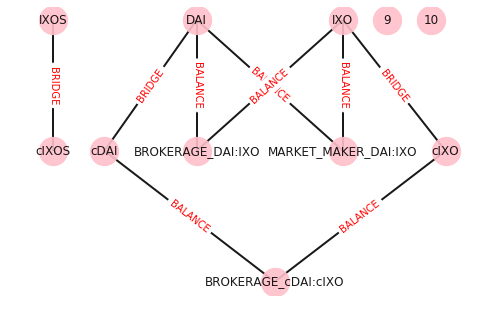

In [ ]:
network, color_map = initialize_network()
pos = nx.drawing.nx_agraph.graphviz_layout(network, prog='dot') #spring_layout(network, k=0.15,iterations=20)

plt.figure()
nx.draw(
    network, pos, edge_color='black', width=2, linewidths=1,
    node_size=800, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

#nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True)

initial_state.update({
    'network': network,
})

### Configure cadCAD

In [ ]:
runs = 1 # Monte Carlo runs

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': runs,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 360),
  'M': {'sweep': 1,
   'amm.kappa': 1,
   'amm.invariant': 10.0,
   'amm.tax_rate': 0,
   'brk.sanity_rate': 10,
   'brk.reasonable_diff': 0.5,
   'brk.rebalance_diff': False,
   'brk.max_spread': 0.02,
   'brk.min_spread': 0.005,
   'max_participants': 120,
   'participant_seed_collateral': 100,
   'supply_pool_tx_rate': 0,
   'supply_pool_tx_count': 6,
   'supply_pool_tx_value': 1000000.0,
   'liquidity_pool_tx_rate': 0.33,
   'liquidity_pool_tx_count': 0,
   'liquidity_pool_tx_value': 100000.0}}]

### Perform Simulation

In [ ]:
# ts_format = '%Y-%m-%d %H:%M:%S'
# t_delta = timedelta(days=30, minutes=0, seconds=0)
# def time_model(_g, step, sL, s, _input):
#     y = 'time'
#     x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
#     return (y, x)

# exogenous_states = {
# #     'time': time_model
# }
# env_processes = {}

partial_state_update_blocks = [
    { # Generate new participants
        'policies': {
            'generate': driving_process,
        },
        'variables': {
            'network': update_network,
        }
    },
    { # Actors enter supply pool
        'policies': {
            'supply': supply_pool_process,
        },
        'variables': {
            'network': update_balances,
        }
    },
    { # Actors provide liquidity via brokerage
        'policies': {
            'liquidity': liquidity_pool_process,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
    {
        'policies': {
            'activity': participant_process,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
#     { # Brokerage rebalance
#         'policies': {
#             'rebalance': brokerage_rebalance,
#         },
#         'variables': {
#             'network': update_brokerage,
#         }
#     },
    { # Accounting
        'policies': {
            'accounting': accounting,
        },
        'variables': {
            'amm.supply': update_supply,
            'amm.reserve': update_reserve,
            'amm.spot_price': update_spot_price,
            'lp.spot_price': update_lp_spot_price,
        }
    },
#     { # Sync networks
#         'policies': {
#             'sync': sync,
#         },
#         'variables': {
#             'network': sync_bridges,
#         }
#     }
]

In [ ]:
append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

sys.setrecursionlimit(10000)
from cadCAD import configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

[{'N': 1, 'T': range(0, 360), 'M': {'sweep': 1, 'amm.kappa': 1, 'amm.invariant': 10.0, 'amm.tax_rate': 0, 'brk.sanity_rate': 10, 'brk.reasonable_diff': 0.5, 'brk.rebalance_diff': False, 'brk.max_spread': 0.02, 'brk.min_spread': 0.005, 'max_participants': 120, 'participant_seed_collateral': 100, 'supply_pool_tx_rate': 0, 'supply_pool_tx_count': 6, 'supply_pool_tx_value': 1000000.0, 'liquidity_pool_tx_rate': 0.33, 'liquidity_pool_tx_count': 0, 'liquidity_pool_tx_value': 100000.0}}]

                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f8681daf1d0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f8681daf1d0>]
Provide liquidity 1000000.0
(0, 0, 0)
voucher_balance 0
859.7890204068747


# Model Data Analysis

In [ ]:
# Choose which experiment parameter configuration to use, integer starting from zero
import os

def select_experiment(results, i):
    df = pd.DataFrame(results[i - 1]['result'])
    directory = './experiment_%s/' % i
    if not os.path.exists(directory):
        os.makedirs(directory)
    return df[df.substep==len(partial_state_update_blocks)].copy()

def save_experiment(fig, experiment, name):
    pickle.dump(fig, open('experiment_%s/%s.pickle' % (experiment, name), 'wb'))
    fig.savefig('experiment_%s/%s.png' % (experiment, name))

In [ ]:
rdf = select_experiment(results, 1)
network_output = rdf['network'][rdf.index[-1]]

pos = nx.drawing.nx_agraph.graphviz_layout(network_output, prog='neato') #spring_layout(network, k=0.15,iterations=20)

node_sizes = [50 if network_output.nodes[node]['_type'] == Nodes.PARTICIPANT.name else 800 for node in network_output.nodes()]

plt.figure(1,figsize=(20,10))
nx.draw(
    network_output, pos, edge_color='black', width=2, linewidths=1,
    node_size=node_sizes, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network_output, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

In [ ]:
select_experiment(results, 1)

In [ ]:
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['IXO_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXO'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf['IXO_pool_growth'])
    plt.title('IXO pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, 'IXO_pool_growth')

In [ ]:
for experiment in params['sweep']:
    data_id = 'IXOS_pool_growth'
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXOS'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('IXOS pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)

In [ ]:
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['DAI_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'DAI'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf['DAI_pool_growth'])
    plt.title('DAI pool growth')
    plt.xlabel('time ($months$)')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, 'IXO_pool_growth')

In [ ]:
market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
edge_id = (market_maker_id, 'DAI')

for experiment in params['sweep']:
    data_id = 'amm.reserve'
    rdf = select_experiment(results, experiment)

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Reserve')
    plt.xlabel('time')
    plt.ylabel('value')

    save_experiment(fig, experiment, data_id)
    print(rdf[data_id])

In [ ]:
market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
edge_id = (market_maker_id, 'DAI')

for experiment in params['sweep']:
    data_id = 'amm.supply'
    rdf = select_experiment(results, experiment)

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Supply')
    plt.xlabel('time')
    plt.ylabel('value')

    save_experiment(fig, experiment, data_id)
    print(rdf[data_id])

In [ ]:
for experiment in params['sweep']:
    data_id = 'amm.spot_price'
    rdf = select_experiment(results, experiment)

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')

    save_experiment(fig, experiment, data_id)
    print('Minimum spot price %s' % min(rdf[data_id]))
    print('Maximum spot price %s' % max(rdf[data_id]))

In [ ]:
for experiment in params['sweep']:
    data_id = 'lp.spot_price'
    rdf = select_experiment(results, experiment)

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')

    save_experiment(fig, experiment, data_id)
    print('Minimum spot price %s' % min(i for i in rdf[data_id] if i > 0))
    print('Maximum spot price %s' % max(rdf[data_id]))